In [ ]:
# import

import sys
import os
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import pandas as pd
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data
import matplotlib.pyplot as plt
from torch.optim import Adam, SGD
from sklearn.metrics import confusion_matrix
from keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input, LSTM, RepeatVector, TimeDistributed
from keras.models import Model
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import BatchNormalization
import keras
from matplotlib.pyplot import figure
from keras.callbacks import EarlyStopping, ModelCheckpoint
import scipy.io as sio

from tensorflow.keras import Sequential
from tensorflow.keras.utils import plot_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = '/content/drive/MyDrive/archive'
print('Available data', os.listdir(data_path))
print('Number of files', len(os.listdir(data_path)))

Available data ['part_1.mat', 'part_10.mat', 'part_11.mat', 'part_12.mat', 'part_2.mat', 'part_3.mat', 'part_4.mat', 'part_5.mat', 'part_6.mat', 'part_7.mat', 'part_8.mat', 'part_9.mat', 'Samples', 'lstm512.h5', 'ppg1.csv', 'ecg1.csv', 'test_ecg.csv', 'test_ppg.csv', 'Ecg2.csv', 'ppg2.csv', 'ppg.csv', 'abp.csv', 'ecg.csv']
Number of files 23


In [ ]:
mat1 = sio.loadmat('/content/drive/MyDrive/archive/part_1.mat')['p'][0]
mat2 = sio.loadmat('/content/drive/MyDrive/archive/part_2.mat')['p'][0]
mat3 = sio.loadmat('/content/drive/MyDrive/archive/part_3.mat')['p'][0]
mat4 = sio.loadmat('/content/drive/MyDrive/archive/part_4.mat')['p'][0]
mat5 = sio.loadmat('/content/drive/MyDrive/archive/part_5.mat')['p'][0]
mat6 = sio.loadmat('/content/drive/MyDrive/archive/part_6.mat')['p'][0]
mat7 = sio.loadmat('/content/drive/MyDrive/archive/part_7.mat')['p'][0]
mat8 = sio.loadmat('/content/drive/MyDrive/archive/part_8.mat')['p'][0]
mat9 = sio.loadmat('/content/drive/MyDrive/archive/part_9.mat')['p'][0]
mat10 = sio.loadmat('/content/drive/MyDrive/archive/part_10.mat')['p'][0]
mat11 = sio.loadmat('/content/drive/MyDrive/archive/part_11.mat')['p'][0]
mat12 = sio.loadmat('/content/drive/MyDrive/archive/part_12.mat')['p'][0]

In [ ]:
data = np.concatenate((mat1, mat2, mat3, mat4, mat5, mat6, mat7, mat8, mat9, mat10, mat11, mat12))

In [ ]:
del mat1
del mat2
del mat3
del mat4
del mat5
del mat6
del mat7
del mat8
del mat9
del mat10
del mat11
del mat12

In [ ]:
print(f"Total Samples: {len(data)}")

Total Samples: 12000


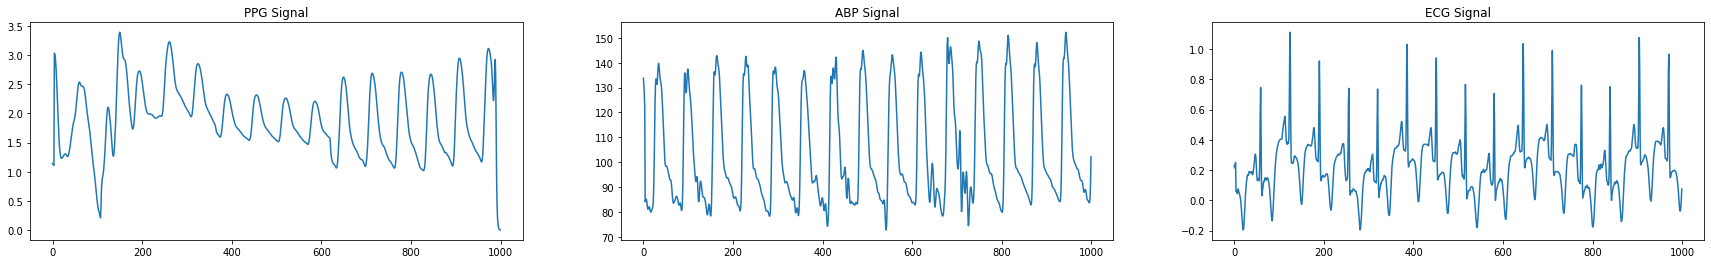

In [ ]:
plt.subplot(1, 3, 1)
plt.plot(data[10][0])
plt.title('PPG Signal')

plt.subplot(1, 3, 2)
plt.plot(data[10][1])
plt.title('ABP Signal')

plt.subplot(1, 3, 3)
plt.plot(data[10][2])
plt.title('ECG Signal')

plt.subplots_adjust(right=4)

In [ ]:
ppg = []
abp = []
ecg = []

for sample in data:
  ppg.append(sample[0][:1000])
  abp.append(sample[1][:1000])
  ecg.append(sample[2][:1000])

pd.DataFrame(ppg).to_csv('/content/drive/MyDrive/archive/ppg.csv', index_label=False)
pd.DataFrame(abp).to_csv('/content/drive/MyDrive/archive/abp.csv', index_label=False)
pd.DataFrame(ecg).to_csv('/content/drive/MyDrive/archive/ecg.csv', index_label=False)

In [ ]:
ppg = pd.read_csv('/content/drive/MyDrive/archive/ppg.csv')
abp = pd.read_csv('/content/drive/MyDrive/archive/abp.csv')
ecg = pd.read_csv('/content/drive/MyDrive/archive/ecg.csv')

In [ ]:
abp = np.divide(np.subtract(abp, 50), 150)

In [ ]:
data = np.stack((ppg, ecg), axis=-1)
X_train = data[:9600]
X_val = data[9600:10800]
X_test = data[10800:]

y_train = abp[:9600]
y_val = abp[9600:10800]
y_test = abp[10800:]

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
# This callback will save the best weight
checkpoint=ModelCheckpoint(
    'bp model/best_model.h5',monitor='val_loss',mode='min',
    save_weight_only=True,save_best_only=True,verbose=1
)
inputs = Input(shape=(1000, 2))
# dense = Dense(128)(inputs)
encoder = LSTM(128, return_sequences=False)(inputs)
encoding_repeat = RepeatVector(1000)(encoder)
decoder = LSTM(128, return_sequences=True)(encoding_repeat)
sequence_prediction = TimeDistributed(Dense(1, activation='linear'))(decoder)
model = Model(inputs, sequence_prediction)
model.compile('adam', 'mse')

model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val,y_val),callbacks=checkpoint)


Epoch 1/100
150/150 [==============================] - ETA: 0s - loss: 0.0305
Epoch 1: val_loss improved from inf to 0.03434, saving model to bp model/best_model.h5
150/150 [==============================] - 30s 93ms/step - loss: 0.0305 - val_loss: 0.0343
Epoch 2/100
150/150 [==============================] - ETA: 0s - loss: 0.0282
Epoch 2: val_loss did not improve from 0.03434
150/150 [==============================] - 14s 91ms/step - loss: 0.0282 - val_loss: 0.0348
Epoch 3/100
150/150 [==============================] - ETA: 0s - loss: 0.0283
Epoch 3: val_loss did not improve from 0.03434
150/150 [==============================] - 13s 90ms/step - loss: 0.0283 - val_loss: 0.0367
Epoch 4/100
150/150 [==============================] - ETA: 0s - loss: 0.0281
Epoch 4: val_loss did not improve from 0.03434
150/150 [==============================] - 14s 92ms/step - loss: 0.0281 - val_loss: 0.0344
Epoch 5/100
150/150 [==============================] - ETA: 0s - loss: 0.0281
Epoch 5: val_loss 

# New Section

# New Section

38/38 [==============================] - 2s 26ms/step


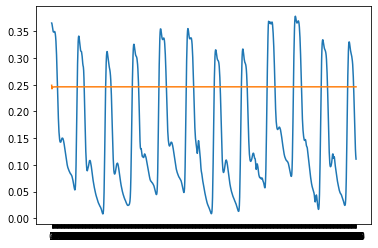

In [ ]:
model.evaluate((X_test),y_test)
prediction = model.predict(X_test)

plt.plot(y_test.iloc[20])
plt.plot(prediction[20])

In [ ]:

from tensorflow.keras.callbacks import ModelCheckpoint
# This callback will save the best weight
checkpoint=ModelCheckpoint(
    '/content/drive/MyDrive/bp model/dence lstm.h5',monitor='val_loss',mode='min',
    save_weight_only=True,save_best_only=True,verbose=1)
inputs = Input(shape=(1000, 2))
# dense = Dense(128)(inputs) #64, 128
encoder = LSTM(256, return_sequences=False)(inputs) #128, 256, 512
do = Dropout(0.1)(encoder)
bn = BatchNormalization()(do)
dense_2 = Dense(1000)(bn)
model = Model(inputs, dense_2)
model.compile('adam', 'mse')
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val,y_val),callbacks=checkpoint)

Epoch 1/100
150/150 [==============================] - ETA: 0s - loss: 0.0512
Epoch 1: val_loss improved from inf to 0.03412, saving model to /content/drive/MyDrive/bp model/dence lstm.h5
150/150 [==============================] - 15s 84ms/step - loss: 0.0512 - val_loss: 0.0341
Epoch 2/100
150/150 [==============================] - ETA: 0s - loss: 0.0285
Epoch 2: val_loss improved from 0.03412 to 0.03348, saving model to /content/drive/MyDrive/bp model/dence lstm.h5
150/150 [==============================] - 12s 83ms/step - loss: 0.0285 - val_loss: 0.0335
Epoch 3/100
150/150 [==============================] - ETA: 0s - loss: 0.0282
Epoch 3: val_loss did not improve from 0.03348
150/150 [==============================] - 12s 79ms/step - loss: 0.0282 - val_loss: 0.0345
Epoch 4/100
150/150 [==============================] - ETA: 0s - loss: 0.0279
Epoch 4: val_loss did not improve from 0.03348
150/150 [==============================] - 12s 79ms/step - loss: 0.0279 - val_loss: 0.0352
Epoch 

38/38 [==============================] - 1s 18ms/step


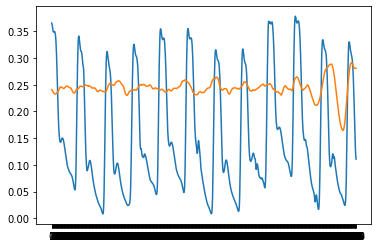

In [ ]:
model.evaluate((X_test),y_test)
prediction = model.predict(X_test)

plt.plot(y_test.iloc[20])
plt.plot(prediction[20])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
# This callback will save the best weight
checkpoint=ModelCheckpoint(
    '/content/drive/MyDrive/bp model/dence_lstm512.h5',monitor='val_loss',mode='min',
    save_weight_only=True,save_best_only=True,verbose=1)
inputs = Input(shape=(1000, 2))
encoder = LSTM(512, return_sequences=False)(inputs) #128, 256, 512
do = Dropout(0.1)(encoder)
bn = BatchNormalization()(do)
dense_2 = Dense(1000)(bn)
model = Model(inputs, dense_2)
model.compile('adam', 'mse')
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val,y_val),callbacks=checkpoint)

Epoch 1/100
150/150 [==============================] - ETA: 0s - loss: 0.0474
Epoch 1: val_loss improved from inf to 0.03437, saving model to /content/drive/MyDrive/bp model/dence_lstm512.h5
150/150 [==============================] - 32s 199ms/step - loss: 0.0474 - val_loss: 0.0344
Epoch 2/100
150/150 [==============================] - ETA: 0s - loss: 0.0286
Epoch 2: val_loss improved from 0.03437 to 0.03389, saving model to /content/drive/MyDrive/bp model/dence_lstm512.h5
150/150 [==============================] - 31s 204ms/step - loss: 0.0286 - val_loss: 0.0339
Epoch 3/100
150/150 [==============================] - ETA: 0s - loss: 0.0284
Epoch 3: val_loss did not improve from 0.03389
150/150 [==============================] - 30s 203ms/step - loss: 0.0284 - val_loss: 0.0350
Epoch 4/100
150/150 [==============================] - ETA: 0s - loss: 0.0279
Epoch 4: val_loss improved from 0.03389 to 0.03326, saving model to /content/drive/MyDrive/bp model/dence_lstm512.h5
150/150 [=========

In [ ]:
model.evaluate((X_test),y_test)
prediction = model.predict(X_test)

plt.plot(y_test.iloc[20])
plt.plot(prediction[20])

NameError: ignored

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
# This callback will save the best weight
checkpoint=ModelCheckpoint(
    '/content/drive/MyDrive/bp model/dence1.h5',monitor='val_loss',mode='min',
    save_weight_only=True,save_best_only=True,verbose=1)
model = Sequential()

model.add(Input(shape=(1000, 2)))
model.add(Dense(128))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Dense(256))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Dense(512))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Dense(256))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Dense(128))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Dense(1, activation='linear'))
model.compile('adam', 'huber')
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val,y_val),callbacks=checkpoint)

Epoch 1/100
150/150 [==============================] - ETA: 0s - loss: 0.1470
Epoch 1: val_loss improved from inf to 0.01698, saving model to /content/drive/MyDrive/bp model/dence1.h5
150/150 [==============================] - 20s 108ms/step - loss: 0.1470 - val_loss: 0.0170
Epoch 2/100
150/150 [==============================] - ETA: 0s - loss: 0.0688
Epoch 2: val_loss improved from 0.01698 to 0.01670, saving model to /content/drive/MyDrive/bp model/dence1.h5
150/150 [==============================] - 16s 109ms/step - loss: 0.0688 - val_loss: 0.0167
Epoch 3/100
150/150 [==============================] - ETA: 0s - loss: 0.0458
Epoch 3: val_loss improved from 0.01670 to 0.01653, saving model to /content/drive/MyDrive/bp model/dence1.h5
150/150 [==============================] - 16s 107ms/step - loss: 0.0458 - val_loss: 0.0165
Epoch 4/100
150/150 [==============================] - ETA: 0s - loss: 0.0308
Epoch 4: val_loss did not improve from 0.01653
150/150 [==============================

38/38 [==============================] - 1s 13ms/step


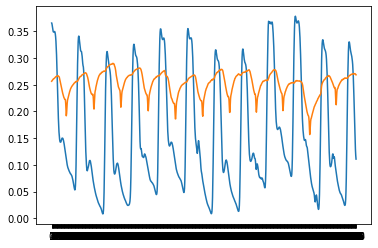

In [ ]:
model.evaluate((X_test),y_test)
prediction = model.predict(X_test)

plt.plot(y_test.iloc[20])
plt.plot(prediction[20])

In [ ]:

model = Sequential()

model.add(Input(shape=(1000, 2)))
model.add(Dense(128))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Dense(256))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Dense(512))
model.add(Dense(1, activation='linear'))
model.compile('adam', 'mse')

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 1000, 128)         384       
                                                                 
 dropout_7 (Dropout)         (None, 1000, 128)         0         
                                                                 
 batch_normalization_7 (Batc  (None, 1000, 128)        512       
 hNormalization)                                                 
                                                                 
 dense_12 (Dense)            (None, 1000, 256)         33024     
                                                                 
 dropout_8 (Dropout)         (None, 1000, 256)         0         
                                                                 
 batch_normalization_8 (Batc  (None, 1000, 256)        1024      
 hNormalization)                                      

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
# This callback will save the best weight
checkpoint=ModelCheckpoint(
    '/content/drive/MyDrive/bp model/dence2.h5',monitor='val_loss',mode='min',
    save_weight_only=True,save_best_only=True,verbose=1)
model = Sequential()

model.add(Input(shape=(1000, 2)))
model.add(Dense(128))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Dense(256))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Dense(512))
model.add(Dense(1, activation='linear'))
model.compile('adam', 'mse')
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val,y_val),callbacks=checkpoint)

Epoch 1/100
150/150 [==============================] - ETA: 0s - loss: 0.3500
Epoch 1: val_loss improved from inf to 0.03422, saving model to /content/drive/MyDrive/bp model/dence2.h5
150/150 [==============================] - 9s 45ms/step - loss: 0.3500 - val_loss: 0.0342
Epoch 2/100
149/150 [============================>.] - ETA: 0s - loss: 0.0289
Epoch 2: val_loss did not improve from 0.03422
150/150 [==============================] - 6s 42ms/step - loss: 0.0289 - val_loss: 0.0351
Epoch 3/100
149/150 [============================>.] - ETA: 0s - loss: 0.0290
Epoch 3: val_loss improved from 0.03422 to 0.03306, saving model to /content/drive/MyDrive/bp model/dence2.h5
150/150 [==============================] - 7s 46ms/step - loss: 0.0290 - val_loss: 0.0331
Epoch 4/100
149/150 [============================>.] - ETA: 0s - loss: 0.0310
Epoch 4: val_loss did not improve from 0.03306
150/150 [==============================] - 6s 42ms/step - loss: 0.0310 - val_loss: 0.0354
Epoch 5/100
149/15

38/38 [==============================] - 2s 48ms/step


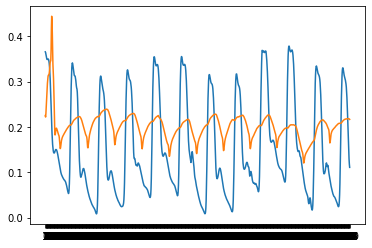

In [ ]:
model.evaluate((X_test),y_test)
prediction = model.predict(X_test)

plt.plot(y_test.iloc[20])
plt.plot(prediction[20])

In [ ]:

from tensorflow.keras.callbacks import ModelCheckpoint
# This callback will save the best weight
checkpoint=ModelCheckpoint(
    '/content/drive/MyDrive/bp model/lstm256.h5',monitor='val_loss',mode='min',
    save_weight_only=True,save_best_only=True,verbose=1)
inputs = Input(shape=(1000, 2))
encoder = LSTM(256, return_sequences=False)(inputs)
do = Dropout(0.1)(encoder)
bn = BatchNormalization()(do)
dense = Dense(1000)(bn)
model = Model(inputs, dense)
model.compile('adam', 'mse')
model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val,y_val),callbacks=checkpoint)

Epoch 1/100
150/150 [==============================] - ETA: 0s - loss: 0.0510
Epoch 1: val_loss improved from inf to 0.03453, saving model to /content/drive/MyDrive/bp model/lstm256.h5
150/150 [==============================] - 14s 81ms/step - loss: 0.0510 - val_loss: 0.0345
Epoch 2/100
150/150 [==============================] - ETA: 0s - loss: 0.0285
Epoch 2: val_loss improved from 0.03453 to 0.03381, saving model to /content/drive/MyDrive/bp model/lstm256.h5
150/150 [==============================] - 12s 81ms/step - loss: 0.0285 - val_loss: 0.0338
Epoch 3/100
150/150 [==============================] - ETA: 0s - loss: 0.0281
Epoch 3: val_loss did not improve from 0.03381
150/150 [==============================] - 12s 80ms/step - loss: 0.0281 - val_loss: 0.0342
Epoch 4/100
150/150 [==============================] - ETA: 0s - loss: 0.0279
Epoch 4: val_loss did not improve from 0.03381
150/150 [==============================] - 12s 79ms/step - loss: 0.0279 - val_loss: 0.0364
Epoch 5/100


38/38 [==============================] - 1s 22ms/step


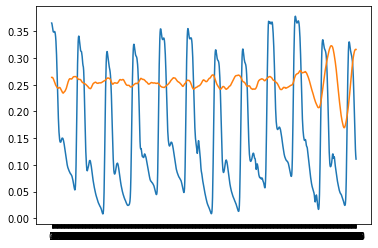

In [ ]:
model.evaluate((X_test),y_test)
prediction = model.predict(X_test)

plt.plot(y_test.iloc[20])
plt.plot(prediction[20])

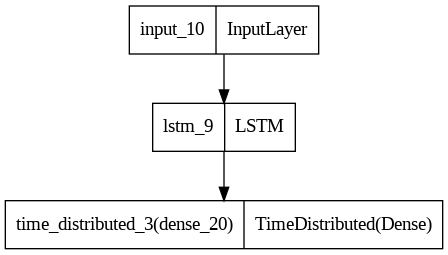

In [ ]:
inputs = Input(shape=(1000, 2))
encoder = LSTM(128, return_sequences=True)(inputs)
sequence_prediction = TimeDistributed(Dense(1, activation='linear'))(encoder)
model = Model(inputs, sequence_prediction)

plot_model(model)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
# This callback will save the best weight
checkpoint=ModelCheckpoint(
    '/content/drive/MyDrive/bp model/lstm128.h5',monitor='val_loss',mode='min',
    save_weight_only=True,save_best_only=True,verbose=1)
inputs = Input(shape=(1000, 2))
encoder = LSTM(128, return_sequences=True)(inputs)
sequence_prediction = TimeDistributed(Dense(1, activation='linear'))(encoder)
model = Model(inputs, sequence_prediction)
model.compile('adam', 'mse')
model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val,y_val),callbacks=checkpoint)

Epoch 1/100


ValueError: ignored

In [ ]:
model.evaluate((X_test),y_test)
prediction = model.predict(X_test)

plt.plot(y_test.iloc[20])
plt.plot(prediction[20])


NameError: ignored

In [ ]:

from tensorflow.keras.callbacks import ModelCheckpoint
# This callback will save the best weight
checkpoint=ModelCheckpoint(
    '/content/drive/MyDrive/bp model/lstm256.h5',monitor='val_loss',mode='min',
    save_weight_only=True,save_best_only=True,verbose=1)
inputs = Input(shape=(1000, 2))
encoder = LSTM(256, return_sequences=True)(inputs)
sequence_prediction = TimeDistributed(Dense(1, activation='linear'))(encoder)
model = Model(inputs, sequence_prediction)
model.compile('adam', 'mse')
model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val,y_val),callbacks=checkpoint)

Epoch 1/100
150/150 [==============================] - ETA: 0s - loss: 0.0300
Epoch 1: val_loss improved from inf to 0.02994, saving model to /content/drive/MyDrive/bp model/lstm256.h5
150/150 [==============================] - 15s 89ms/step - loss: 0.0300 - val_loss: 0.0299
Epoch 2/100
150/150 [==============================] - ETA: 0s - loss: 0.0251
Epoch 2: val_loss improved from 0.02994 to 0.02986, saving model to /content/drive/MyDrive/bp model/lstm256.h5
150/150 [==============================] - 13s 87ms/step - loss: 0.0251 - val_loss: 0.0299
Epoch 3/100
150/150 [==============================] - ETA: 0s - loss: 0.0228
Epoch 3: val_loss did not improve from 0.02986
150/150 [==============================] - 13s 85ms/step - loss: 0.0228 - val_loss: 0.0305
Epoch 4/100
150/150 [==============================] - ETA: 0s - loss: 0.0313
Epoch 4: val_loss did not improve from 0.02986
150/150 [==============================] - 13s 83ms/step - loss: 0.0313 - val_loss: 0.0325
Epoch 5/100


In [ ]:
model.evaluate((X_test),y_test)
prediction = model.predict(X_test)

plt.plot(y_test.iloc[20])
plt.plot(prediction[20])

NameError: ignored

In [ ]:

from tensorflow.keras.callbacks import ModelCheckpoint
# This callback will save the best weight
checkpoint=ModelCheckpoint(
    '/content/drive/MyDrive/bp model/lstm512.h5',monitor='val_loss',mode='min',
    save_weight_only=True,save_best_only=True,verbose=1)
inputs = Input(shape=(1000, 2))
encoder = LSTM(512, return_sequences=True)(inputs)
sequence_prediction = TimeDistributed(Dense(1, activation='linear'))(encoder)
model = Model(inputs, sequence_prediction)
model.compile('adam', 'mse')
model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val,y_val),callbacks=checkpoint)

NameError: ignored

38/38 [==============================] - 2s 48ms/step


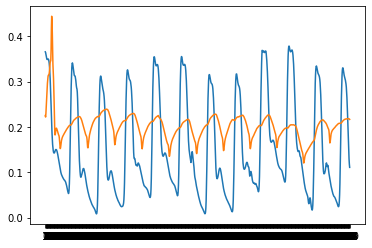

In [ ]:
model.evaluate((X_test),y_test)
prediction = model.predict(X_test)
plt.plot(y_test.iloc[20])
plt.plot(prediction[20])


In [ ]:
import tensorflow as tf
model=tf.keras.models.load_model('C:\Users\ahmed\OneDrive\Desktop\lstm512.h5')

In [ ]:
ecg=pd.read_csv('/content/drive/MyDrive/archive/Ecg2.csv')
ppg=pd.read_csv('/content/drive/MyDrive/archive/ppg2.csv')
ecg=ecg[:1000]
ppg=ppg[:1000]
ecg


,40
0,41
1,45
2,43
3,37
4,52
...,...
995,569
996,581
997,602
998,581


In [ ]:
x=ppg.transpose()
y=ecg.transpose()
x.shape

(1, 1000)

In [ ]:
data = np.stack((x, y), axis=-1)
data.shape


(1, 1000, 2)

In [ ]:
prediction=model.predict(data)

1/1 [==============================] - 1s 830ms/step


In [ ]:
prediction.shape

(1, 1000)

In [ ]:
s=sum((prediction[0]*150)+50)/1000
print(s)

98.81287461090088


[ 99.022766  98.957855  98.81053   98.77166   98.14269   98.18565
  97.91825   97.44956   97.08073   97.204735  96.736755  96.30798
  96.098656  95.311676  95.00011   94.73741   94.12657   93.66586
  94.19917   93.91788   94.57936   95.344604  96.20199   97.17926
  98.32284   99.188866 100.61645  101.37076  102.170334 102.835205
 103.40451  103.57068  103.908554 103.69359  103.62909  102.87245
 102.76936  102.096855 101.52141  100.517456  99.7404    98.70676
  98.488235  97.87929   96.75077   96.83614   96.57377   96.49206
  96.53317   96.832     96.99023   97.56828   97.769745  98.11675
  98.36361   97.88313   97.600784  97.25424   97.32608   97.827515
  97.68298   97.97798   98.95822   99.05316   99.11363   99.654175
  99.7659   100.06195   99.96912   99.74268   99.011795  98.7043
  98.3448    98.60642   98.78021   98.71297   99.10292   99.441696
  99.967224 100.12744  100.864395 100.124504 100.15233  100.10474
 100.02382  100.06439  100.01757   99.684616  99.69745   99.618454
  99.4

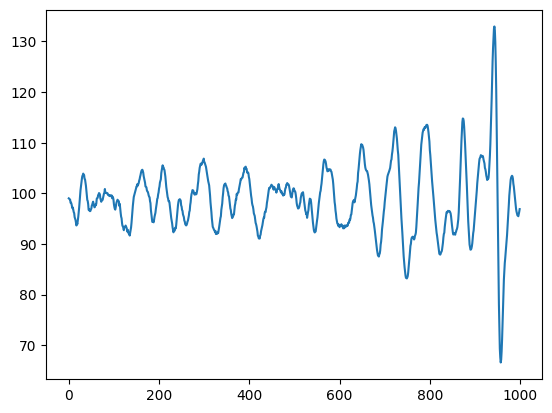

In [ ]:
print((prediction[0]*150)+50)
plt.plot((prediction[0]*150)+50)